# Project 1: EDA: King County House Pricing Data Set
## Final Project Submission

Please fill out:
* Student name: Bendix Haß


## Setup

Core setup for the Notebook. You will find all imported packages etc. here.

In [126]:
reset -fs

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf

## Business Understanding

Ask relevant questions and define objectives for the problem that need to be tackled

### General
* ~34400 households
* 27000 families
* economy agriculturally dominant
* demographics:
    * median household income in the county was \$47,035
    * 17.6\% of the population was below the poverty line.
    * average per capita income \$35,306: ranked last of California's 58 counties.
* major employers:
    * NAS Lemoore
    * Del Monte Foods 
    * Adventist Health
    * J. G. Boswell Company
    * Leprino Foods
    * Kings County Government and the California Department of Corrections and Rehabilitation

### BUILDING CONDITION

[Source](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

Relative to age and grade. Coded 1-5.

    1 = Poor- Worn out.
    2 = Fair- Badly worn.
    3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing.
    4 = Good- No obvious maintenance required.
    5= Very Good- All items well maintained.

### BUILDING GRADE

[Source](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

    1-3 Falls short of minimum building standards. Normally cabin or inferior structure.
    4 Generally older, low quality construction. Does not meet code.
    5 Low construction costs and workmanship. Small, simple design.
    6 Lowest grade currently meeting building code. Low quality materials and simple designs.
    7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.
    8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
    9 Better architectural design with extra interior and exterior design and quality.
    10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
    11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
    12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
    13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

### Role of King County prisons
* 12,2% of population imprisoned
* highest  incarceration rate of California countys
* King's County jail (36.332618, -119.669376)
* California State prison Corcoran (36.060564, -119.549428)
* Avenal State Prison (35.973078, -120.119543)
* Pleasant Valley State Prison (36.128039, -120.237817)

## Data Mining

Gather and scrape the data necessary for the project

### Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **date** - Date house was sold
* **price** - Price: is prediction target
* **bedrooms** - Number of Bedrooms/House
* **bathrooms** - Number of bathrooms/bedrooms
* **sqft_living** - square footage of the home
* **sqft_lot** - square footage of the lot
* **floors** - Total floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [128]:
df = pd.read_csv('King_County_House_prices_dataset.csv', delimiter=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [129]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Data Cleaning

Fix the inconsistencies within the data and handle the missing values

### Handling NaN
1. NaN - We have missing data in the Features: **view**, **waterfront** and **yr_renovated**.

In [148]:
df.nunique()

id               21420
date             21420
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      303
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

In [176]:
# Sequence data by continuous/categorical/misc
continuous = ['date', 'price', 'bedrooms', 'bathrooms'
              , 'sqft_living', 'sqft_lot', 'floors'
              , 'sqft_above', 'sqft_basement', 'yr_built'
              , 'yr_renovated', 'zipcode', 'lat', 'long'
              , 'sqft_living15', 'sqft_lot15']

categorical = ['waterfront', 'view', 'condition', 'grade']
misc = ['id']

# all([i in continuous+categorical+misc for i in df.columns]) #to check

True

In [149]:
# I wonder why baths is a floating point variable
df.bathrooms.unique()

# conclusion: it follows a calculation of quarter baths
# bath: toilet = 0.25, toilet + sink = 0.5, toilet + sink + shower = 0.75, toilet + sink + shower + tub = 1

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 0.5 , 5.5 ,
       6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [150]:
# I wonder why floors is a floating point variable
df.floors.unique()

# conclusion: stories under a pitched roof are .5 floors

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [151]:
# I wonder why waterfront is a floating point variable
df.waterfront.unique()

# conclusion: can be casted to integer after NaNs are handled

array([0, 1])

In [152]:
# What is the expected value for waterfront?
df.waterfront.value_counts()

0    21451
1      146
Name: waterfront, dtype: int64

In [153]:
# <1% are at a waterfront.
# I will replace nan-values by 0 (not expected to be at waterfront)
df.waterfront.replace(to_replace=[np.nan], value=0, inplace=True);

In [154]:
# I wonder why view is a floating point variable
df.view.unique()

# conclusion: view can be casted to int64 after handling NaNs

array([0, 3, 4, 2, 1])

In [155]:
df.view.value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

In [156]:
# ~10% have a view of 0.
# I will replace nan-values by 0
df.view.replace(to_replace=[np.nan], value=0, inplace=True);

In [157]:
# I wonder why yr_renovated is a floating point variable
df.yr_renovated.unique()

# conclusion: yr_renovated can be casted to int64 after handling NaNs

array([   0, 1991, 2002, 2010, 1992, 2013, 1994, 1978, 2005, 2003, 1984,
       1954, 2014, 2011, 1983, 1945, 1990, 1988, 1977, 1981, 1995, 2000,
       1999, 1998, 1970, 1989, 2004, 1986, 2007, 1987, 2006, 1985, 2001,
       1980, 1971, 1979, 1997, 1950, 1969, 1948, 2009, 2015, 1974, 2008,
       1968, 2012, 1963, 1951, 1962, 1953, 1993, 1996, 1955, 1982, 1956,
       1940, 1976, 1946, 1975, 1964, 1973, 1957, 1959, 1960, 1967, 1965,
       1934, 1972, 1944, 1958])

In [158]:
df.yr_renovated.value_counts(dropna=False)
# 79% has not been renovated
# 18% is NaN
# conclusion: NaN will be replaced by 0
df.yr_renovated.replace(to_replace=[np.nan], value=0, inplace=True);

In [159]:
# I wonder why sqft_basement is of type object
df.sqft_basement.unique()

# conclusion: sqft_basement contains '?' but could be casted to int64

array([   0,  400,  910, 1530,  730, 1700,  300,  970,  760,  720,  700,
        820,  780,  790,  330, 1620,  360,  588, 1510,  410,  990,  600,
        560,  550, 1000, 1600,  500, 1040,  880, 1010,  240,  265,  290,
        800,  540,  710,  840,  380,  770,  480,  570, 1490,  620, 1250,
       1270,  120,  650,  180, 1130,  450, 1640, 1460, 1020, 1030,  750,
        640, 1070,  490, 1310,  630, 2000,  390,  430,  850,  210, 1430,
       1950,  440,  220, 1160,  860,  580, 2060, 1820, 1180,  200, 1150,
       1200,  680,  530, 1450, 1170, 1080,  960,  280,  870, 1100,  460,
       1400,  660, 1220,  900,  420, 1580, 1380,  475,  690,  270,  350,
        935, 1370,  980, 1470,  160,  950,   50,  740, 1780, 1900,  340,
        470,  370,  140, 1760,  130,  520,  890, 1110,  150, 1720,  810,
        190, 1290,  670, 1800, 1120, 1810,   60, 1050,  940,  310,  930,
       1390,  610, 1830, 1300,  510, 1330, 1590,  920, 1320, 1420, 1240,
       1960, 1560, 2020, 1190, 2110, 1280,  250, 23

In [160]:
# sqft_basement has '?' values. 
# It cannot be casted to int64
# Those '?' will be replaced by the mode
df.sqft_basement.replace(to_replace=['?'], value=df.sqft_basement.mode(), inplace=True);

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

### Data types

Most of the data types are expected. Unexpected are listed below:
1. **date** should be a DateTime type
2. **price** can be integer. Decimal float point values are of no interest
3. **bathrooms** follows this calculation: [bath](https://illinado.com/what-is-a-quarter-bath/)
4. **floors** .5-values are pitched-roof stories
5. **waterfront**, **view**, **yr_renovated**, **sqft_basement** can be cast to integer

In [ ]:
# Casting Series types:
df.date = df.astype({'date':'datetime64'})

# casting from object -> float -> round -> int necessary
for feat in ['price', 'waterfront', 'view', 'yr_renovated', 'sqft_basement']:
    df[feat] = df[feat].astype(float).round(0).astype(int)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null int64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null int64
view             21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(4), int64(16), object(1)
memory usage: 3.5+ MB


### Inconsistent data:
1. **ID**: some houses seem to be doubled: dataset has 21597 entries but only 21420 unique IDs

In [173]:
df.id.value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
3969300030    2
2560801222    2
3883800011    2
2228900270    2
251300110     2
5282200015    2
2787460720    2
5536100020    2
2568300045    2
8648900110    2
8910500150    2
2044500213    2
4222310010    2
8651402750    2
8820903380    2
4345000510    2
641900050     2
1823049202    2
8121100395    2
6308000010    2
1139600270    2
937000330     2
3293700496    2
4435000705    2
5430300171    2
             ..
9454200030    1
8857640710    1
7519001825    1
3992700130    1
7515000035    1
5608010980    1
475000510     1
4038300010    1
2770603522    1
2738640470    1
9238480020    1
9492500170    1
2607740100    1
880000189     1
7974200510    1
6815100095    1
2617300160    1
2768100545    1
3324069058    1
1931300035    1
1922000070    1
8165500110    1
7893808220    1
3333002440    1
3420069065    1
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420,

## Data Exploration

Find hypothesis about your defined problem by visually analyzing the data

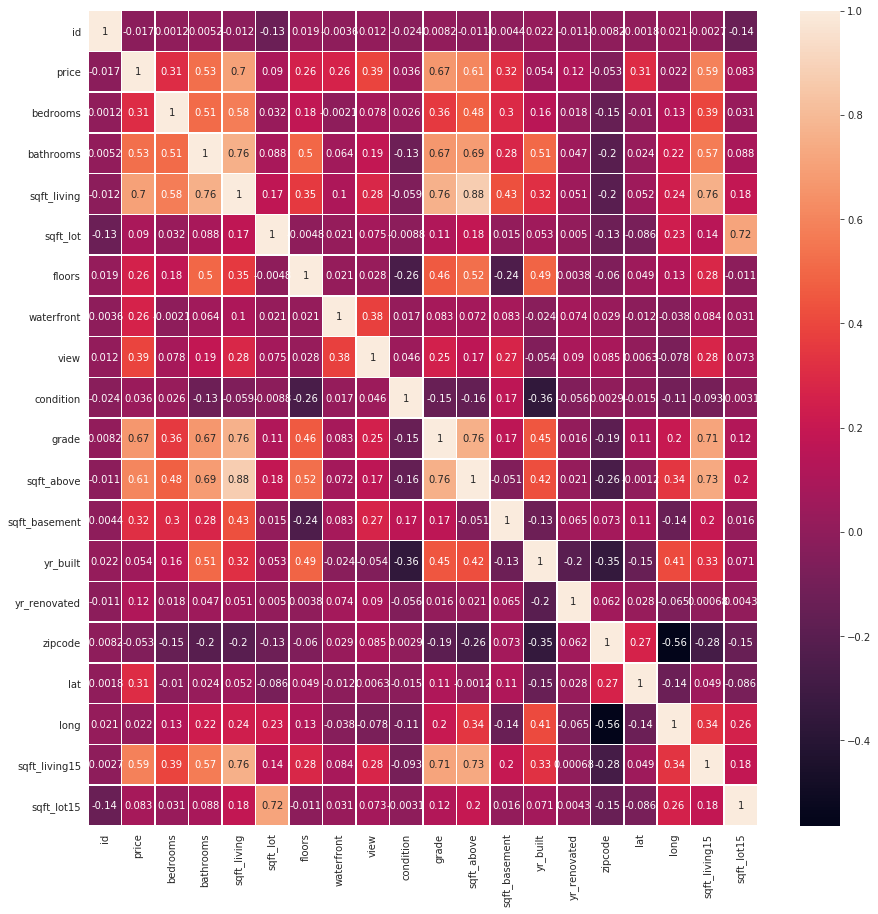

In [217]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(df.corr(), annot=True, linewidths=.5)

In [220]:
# Filter some misc and categorical features that won't add insights to the plot
showpairplot = [i for i in df.columns 
                if i not in ['id', 'yr_renovated'
                             , 'waterfront', 'view'
                             ,'long', 'lat', 'zipcode'
                             , 'sqft_lot15', 'yr_built'
                             , 'condition', 'sqft_lot']]
# only print 30% value for better performance:
# msk = np.random.rand(df.id.count(),1) > 0.9
# df[msk].id.count()

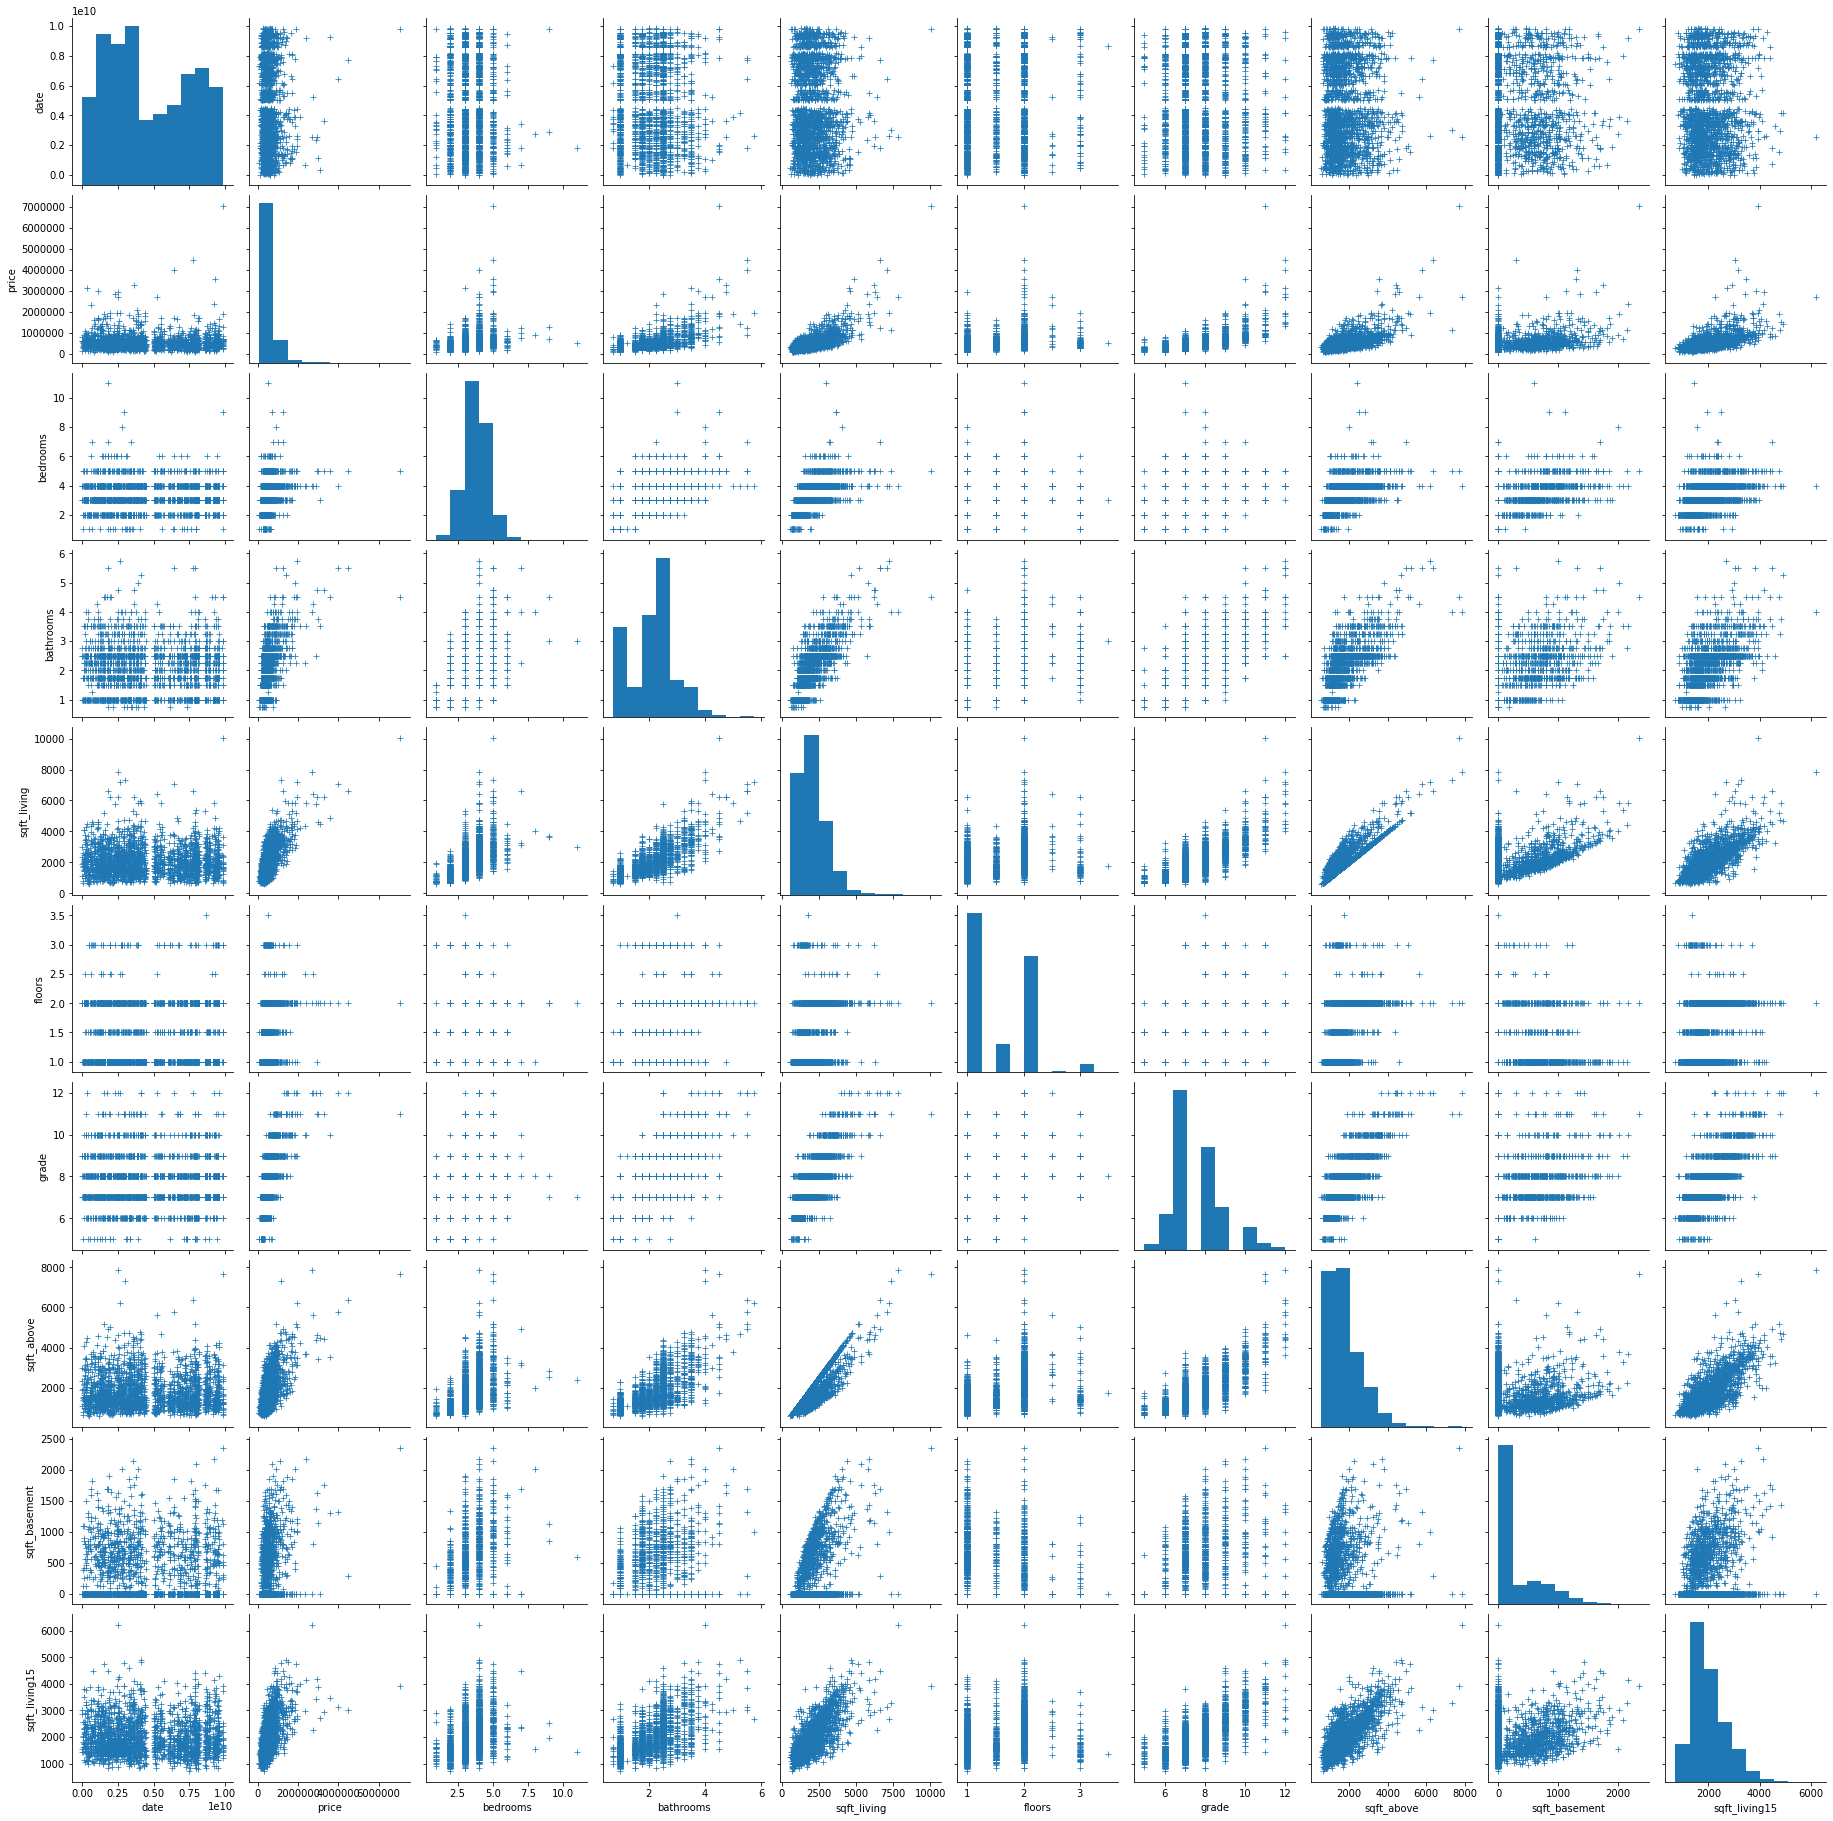

In [226]:
sns.pairplot(df[msk][showpairplot]
             #, hue='condition'
             #, diag_kind='kde'
             #, kind='reg'
             , markers="+"
             #, plot_kws=dict(edgecolor="b", linewidth=.1)
             #, diag_kws=dict(shade=True)
            )

## Feature Engineering

Select important features and construct more meaningful ones using the raw data you that have

1. Total number of bathrooms
2. 

## Predictive Modeling

Train machine learning models, evaluate their performance and use them to make predictions

## Data Visualization

Communicate the findings with key stakeholder using plots and interactive visualizations

## Future Work